In [2]:
#!pip install mlflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector

In [4]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Encoding step, this is done to covner the categorical columns into numreical.

In [5]:
label_encoders = {}
for column in ['Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope','ChestPainType']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [6]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


Checking the nullvalues

In [7]:
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


Assigning the target and features

In [8]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

Comparing the classification values, seeing if the data is imbalanced. A 55/45 split is fairly balanced.

<Axes: ylabel='count'>

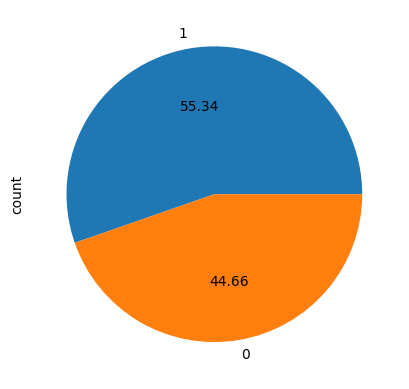

In [9]:
y.value_counts().plot.pie(autopct = '%.2f')

Splitting into train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling the data, which makes sure that all contribute equally to the training process. Without doing this, large values heavily manipulate the model.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Assigning a logistic regression model

In [12]:
model = LogisticRegression(max_iter=1000)

Using sequential feature selector, it selects the best features/most important to predict heart diseases.

In [13]:
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')
sfs.fit(X_train_scaled, y_train)
selected_features = X.columns[sfs.get_support()]

Now we assign the features to the variables

In [14]:
X_train_sfs = sfs.transform(X_train_scaled)
X_test_sfs = sfs.transform(X_test_scaled)

Training the model.

In [15]:
model.fit(X_train_sfs,y_train)

LogisticRegression(max_iter=1000)

storing the predictions in a variable

In [16]:
y_pred = model.predict(X_test_sfs)

Accuracy metrics

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8043478260869565
Precision: 0.8380952380952381
Recall: 0.822429906542056
F1-score: 0.8301886792452831


In [18]:
mlflow.set_experiment("Heart Disease Prediction")
with mlflow.start_run():
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_metric("f1 score", f1)
    joblib.dump(model, "HeartDiseaseModel.pkl")
    mlflow.log_artifact("HeartDiseaseModel.pkl")
mlflow.end_run()

2025/06/14 20:45:50 INFO mlflow.tracking.fluent: Experiment with name 'Heart Disease Prediction' does not exist. Creating a new experiment.
